# Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from numpy import pi
import torch
import cv2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
pathMesh = "../DEM analysis/Final_refined_Mesh.stl"
FinalRefinedMesh = o3d.io.read_triangle_mesh(pathMesh)
FinalRefinedMesh.remove_duplicated_vertices()
FinalRefinedMesh.remove_duplicated_triangles()

TriangleMesh with 492247 points and 981677 triangles.

In [4]:
Vertices = np.asarray(FinalRefinedMesh.vertices)
TrianglesIndex = np.asarray(FinalRefinedMesh.triangles)
Triangles = Vertices[TrianglesIndex]

In [5]:
def Custom_Visualizer_Mesh(obj):
    width=1820
    vis = o3d.visualization.Visualizer()
    vis.create_window('Open3D', width, height=980,
                      left=int(0.5*(1920-width)), top=35, visible=True)
    vis.add_geometry(obj)

    RenderOpt = vis.get_render_option()
    RenderOpt.show_coordinate_frame= True
    RenderOpt.mesh_show_wireframe = True
    
    #RenderOpt.PointColorOption = 9
    #obj.vertex_colors = obj.vertex_normals
    RenderOpt.mesh_color_option = o3d.visualization.MeshColorOption.ZCoordinate
    
    #print(dir(RenderOpt.mesh_color_option.Color.ZCoordinate))
    #obj.paint_uniform_color([1, 0.706, 0])
    #img = vis.capture_screen_float_buffer(True)
    
    vis.run()
    vis.destroy_window()
    return #img

In [6]:
Custom_Visualizer_Mesh(FinalRefinedMesh)

In [7]:
#plt.imshow(np.asarray(im))

In [8]:
vis = o3d.visualization.Visualizer()
RenderOpt = vis.get_render_option()

In [9]:
dir(RenderOpt)

['__bool__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

# Open3D

In [10]:
def Model_View_Matrix(Cam_x, Cam_y, Cam_z, pitch_x, heading_y, roll_z):

    from numpy.linalg import multi_dot

    tvec = - np.array([Cam_x, Cam_y, Cam_z]) 

    M_trans_H = np.identity(4)
    M_trans_H[0:3,-1] = tvec

    theta = np.array([pitch_x,heading_y,roll_z])*(pi/180)

    R_pitch_x = np.array([[1,         0,                  0                ],
                          [0,         np.cos(theta[0]),  -np.sin(theta[0]) ],
                          [0,         np.sin(theta[0]),   np.cos(theta[0]) ] ])


    R_heading_y = np.array([[np.cos(theta[1]),    0,      np.sin(theta[1])  ],
                            [0,                     1,      0                   ],
                            [-np.sin(theta[1]),   0,      np.cos(theta[1])  ]
                            ])

    R_roll_z = np.array([[np.cos(theta[2]),    -np.sin(theta[2]),    0],
                        [np.sin(theta[2]),    np.cos(theta[2]),     0],
                        [0,                     0,                      1]
                        ])

    R_pitch_x_H = np.concatenate( (np.concatenate((R_pitch_x, np.array([[0],[0],[0]])), axis=1),
                     np.array([[0,0,0,1]])), axis=0)
    R_heading_y_H = np.concatenate( (np.concatenate((R_heading_y, np.array([[0],[0],[0]])), axis=1),
                     np.array([[0,0,0,1]])), axis=0)
    R_roll_z_H = np.concatenate( (np.concatenate((R_roll_z, np.array([[0],[0],[0]])), axis=1),
                     np.array([[0,0,0,1]])), axis=0)

    ViewMatrix = multi_dot([ R_roll_z_H, R_heading_y_H,  R_pitch_x_H, M_trans_H])   
    ModelMatrix = np.identity(4)
    Model_View_Matrix = np.matmul(ViewMatrix, ModelMatrix)

    return Model_View_Matrix   

In [11]:
def Rotation_Matrix(pitch_x, heading_y, roll_z):

    from numpy.linalg import multi_dot

    theta = np.array([pitch_x, heading_y, roll_z])*(pi/180)
    R_pitch_x = np.array([[1,         0,                  0                ],
                          [0,         np.cos(theta[0]),  -np.sin(theta[0]) ],
                          [0,         np.sin(theta[0]),   np.cos(theta[0]) ] ])

    R_heading_y = np.array([[np.cos(theta[1]),    0,      np.sin(theta[1])  ],
                            [0,                     1,      0                   ],
                            [-np.sin(theta[1]),   0,      np.cos(theta[1])  ]
                            ])

    R_roll_z = np.array([[np.cos(theta[2]),    -np.sin(theta[2]),    0],
                        [np.sin(theta[2]),    np.cos(theta[2]),     0],
                        [0,                     0,                      1]
                        ])

    RotationMatrix = multi_dot([ R_roll_z, R_heading_y,  R_pitch_x])   
    
    return RotationMatrix

def OpenGLandCV_to_Open3D_Angles_deg(OpenGLandCV_angles):
    Coordinate_Rotate = Rotation_Matrix(180,0,0).round(1)
    OP3D_angles = np.matmul(Coordinate_Rotate, OpenGLandCV_angles)-np.array([180,0,0])
    return OP3D_angles

def Open3D_to_OpenGLandCV_Angles_deg(OP3D_angles):
    Coordinate_Rotate = Rotation_Matrix(180,0,0).round(1)
    OpenGLCV_angles = np.matmul(Coordinate_Rotate, OP3D_angles)+np.array([180,0,0])
    return OpenGLCV_angles

In [12]:
def Custom_Visualizer_CameraPose_FOV_Complete(obj,
                                              Cam_x, Cam_y, Cam_z,
                                              pitch_x, heading_y, roll_z,
                                              fov, Width_img, Height_img):
            
    
    Extrinsic_H = Model_View_Matrix(Cam_x, Cam_y, Cam_z,
                  pitch_x, heading_y, roll_z)
    
    
    vis = o3d.visualization.Visualizer()
    vis.create_window('camera_view', Width_img, Height_img,
                      left=int(0.5*(2496-Width_img)), top=55, visible=True)
    vis.add_geometry(obj)

    view_ctl = vis.get_view_control()  # Everything good
    
    fov_add = (fov-60)/5.
    #print(view_ctl.get_field_of_view())
    view_ctl.change_field_of_view(step=fov_add)
    #print(view_ctl.get_field_of_view())
    
    cam = view_ctl.convert_to_pinhole_camera_parameters()
  
    cam.extrinsic = Extrinsic_H  
    

    
    view_ctl.convert_from_pinhole_camera_parameters(cam)
    
    
    
    RenderOpt = vis.get_render_option()
    RenderOpt.show_coordinate_frame= True
    RenderOpt.mesh_show_wireframe = True
    RenderOpt.mesh_color_option = o3d.visualization.MeshColorOption.ZCoordinate
    
    
    
    
    #vis.update_geometry()

    vis.poll_events()
    vis.update_renderer()
    vis.capture_screen_image('./zImage.jpeg')
    
    img = vis.capture_screen_float_buffer(True)
    
    vis.run()
    vis.destroy_window()
    

    return view_ctl, img

In [13]:
OCV_Angles = np.array([269.69094211, -62.2301418 ,  -0.36972229])
O3D_Angles = OpenGLandCV_to_Open3D_Angles_deg(OCV_Angles)


CPose_x = 649323.4946735367
CPose_y = 142744.31005438883
CPose_z = 2805.999091620659

CPose_pitch_x = O3D_Angles[0]
CPose_heading_y = O3D_Angles[1]
CPose_roll_z = O3D_Angles[2]

ImageWidth = 961 
ImageHeight = 418 
FOV = 26.458304037158854
#################################################################
Loc = np.array([CPose_x, CPose_y, CPose_z])
Angles = np.array([CPose_pitch_x, CPose_heading_y, CPose_roll_z])

In [14]:
# OCV_Angles = np.array([270, -30 ,  0])    
# # CPose_pitch_x --> should be 270 + a (a is toward down)
# # CPose_heading_y --> 0 means y_axis in scatter plot of DEM
# # CPose_roll_z --> should be around 0

# O3D_Angles = OpenGLandCV_to_Open3D_Angles_deg(OCV_Angles)
# print(O3D_Angles)

# CPose_x = 646000.0877
# CPose_y = 135000.0341
# CPose_z = 4219

# CPose_pitch_x = O3D_Angles[0]
# CPose_heading_y = O3D_Angles[1]
# CPose_roll_z = O3D_Angles[2]

# ImageWidth = 1500 
# ImageHeight = 1500 
# FOV = 60
# #################################################################
# Loc = np.array([CPose_x, CPose_y, CPose_z])
# Angles = np.array([CPose_pitch_x, CPose_heading_y, CPose_roll_z])

In [15]:
CamParams, renderedIMG = Custom_Visualizer_CameraPose_FOV_Complete(FinalRefinedMesh,
                                                      Loc[0],Loc[1],Loc[2],
                                                      Angles[0],Angles[1],Angles[2],
                                                      FOV, ImageWidth, ImageHeight)

In [16]:
def ResizeWithAspectRatio(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    return cv2.resize(image, dim, interpolation=inter)

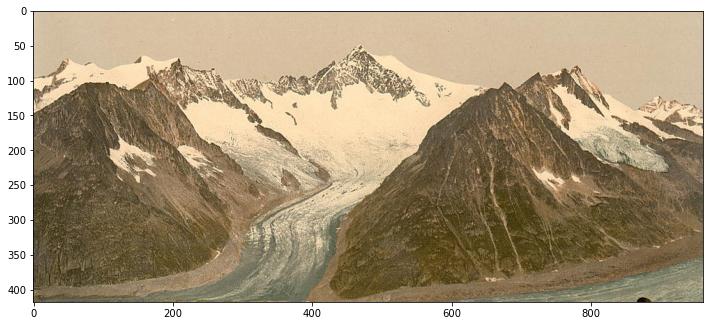

In [17]:
Mountain = cv2.imread('../Corner Detection/Mountain_cropped.jpg')
scalefactor=1
Mountain2=ResizeWithAspectRatio(Mountain,width=int(Mountain.shape[1]*scalefactor))

fig= plt.figure(figsize=(12,15))
plt.imshow(Mountain2[:,:,::-1])
plt.show()

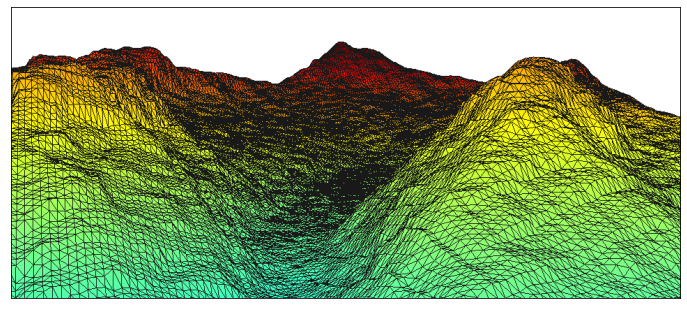

In [18]:
fig= plt.figure(figsize=(12,12))
plt.imshow(Mountain2[:,:,::-1])
plt.imshow(np.asarray(renderedIMG), alpha=0.25)
plt.imshow(np.asarray(renderedIMG))
ax=plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

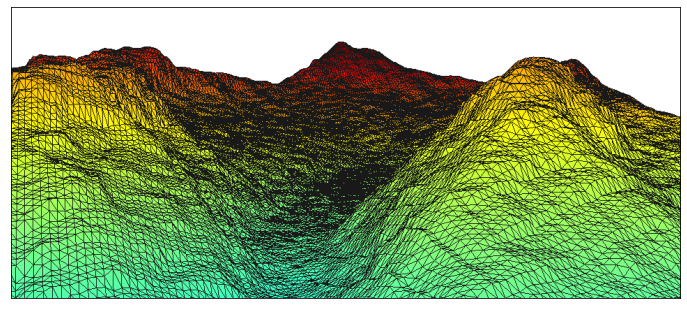

In [19]:
fig= plt.figure(figsize=(12,12))

plt.imshow(np.asarray(renderedIMG))
# plt.imshow(Mountain2[:,:,::-1], alpha=0.0)
ax=plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

# OpenGL

In [42]:
def Model_View_Matrix(Cam_x, Cam_y, Cam_z, pitch_x, heading_y, roll_z):

    from numpy.linalg import multi_dot

    tvec = - np.array([Cam_x, Cam_y, Cam_z]) 

    M_trans_H = np.identity(4)
    M_trans_H[0:3,-1] = tvec

    theta = np.array([pitch_x,heading_y,roll_z])*(pi/180)

    R_pitch_x = np.array([[1,         0,                  0                ],
                          [0,         np.cos(theta[0]),  -np.sin(theta[0]) ],
                          [0,         np.sin(theta[0]),   np.cos(theta[0]) ] ])


    R_heading_y = np.array([[np.cos(theta[1]),    0,      np.sin(theta[1])  ],
                            [0,                     1,      0                   ],
                            [-np.sin(theta[1]),   0,      np.cos(theta[1])  ]
                            ])

    R_roll_z = np.array([[np.cos(theta[2]),    -np.sin(theta[2]),    0],
                        [np.sin(theta[2]),    np.cos(theta[2]),     0],
                        [0,                     0,                      1]
                        ])

    R_pitch_x_H = np.concatenate( (np.concatenate((R_pitch_x, np.array([[0],[0],[0]])), axis=1),
                     np.array([[0,0,0,1]])), axis=0)
    R_heading_y_H = np.concatenate( (np.concatenate((R_heading_y, np.array([[0],[0],[0]])), axis=1),
                     np.array([[0,0,0,1]])), axis=0)
    R_roll_z_H = np.concatenate( (np.concatenate((R_roll_z, np.array([[0],[0],[0]])), axis=1),
                     np.array([[0,0,0,1]])), axis=0)

    ViewMatrix = multi_dot([ R_roll_z_H, R_heading_y_H,  R_pitch_x_H, M_trans_H])   
    ModelMatrix = np.identity(4)
    Model_View_Matrix = np.matmul(ViewMatrix, ModelMatrix)

    return Model_View_Matrix   

def Projection_Matrix(ImageHeight, ImageWidth, FOV):
    L = - ImageWidth//2    # when symmetric frustum: L+R=0
    R = ImageWidth//2

    B = - ImageHeight//2
    T = ImageHeight//2   # when symmetric frustum: T+B=0

    N = T/np.tan((FOV/2)*(pi/180.))
    F = 10*N

    Projection_Matrix = np.array(
    [[2*N/(R-L)  ,  0         ,  (R+L)/(R-L),   0         ],
     [0          ,  2*N/(T-B) ,  (T+B)/(T-B),   0         ],
     [0          ,  0         , -(F+N)/(F-N),  -2*F*N/(F-N)],
     [0          ,  0         , -1          ,   0         ]])

    return Projection_Matrix

def Projecting_World_Points(C_x, C_y, C_z, Pitch_x, Heading_y, Roll_z,
                            ImageHeight, ImageWidth, FOV, XYZ_world):

    XYZ_h = np.concatenate(( XYZ_world, np.full(XYZ_world.shape[0],1).reshape(-1,1) ), axis=1)
    ModelView_Mat = Model_View_Matrix(C_x, C_y, C_z, Pitch_x, Heading_y, Roll_z)

    XYZ_eye_h = np.matmul(ModelView_Mat, XYZ_h[:, :, None]).squeeze(-1)

    ProjMat = Projection_Matrix(ImageHeight, ImageWidth, FOV)
    
    XYZ_clip_h = np.matmul(ProjMat, XYZ_eye_h[:, :, None]).squeeze(-1)

    X_clip_bool_1 = (XYZ_clip_h[:,0] > -XYZ_clip_h[:,3])
    X_clip_bool_2 = (XYZ_clip_h[:,0] <  XYZ_clip_h[:,3])
    Y_clip_bool_1 = (XYZ_clip_h[:,1] > -XYZ_clip_h[:,3])
    Y_clip_bool_2 = (XYZ_clip_h[:,1] <  XYZ_clip_h[:,3])    
    
    ClippedVisIndex = np.where(X_clip_bool_1*X_clip_bool_2*Y_clip_bool_1*Y_clip_bool_2 == True)[0]
    ClippedInvisIndex = np.where(X_clip_bool_1*X_clip_bool_2*Y_clip_bool_1*Y_clip_bool_2 == False)[0]
    
#     XYZ_ndc = np.copy(XYZ_clip_h[ClippedVisIndex][:,0:3])/XYZ_clip_h[ClippedVisIndex][:,3].reshape(-1,1)
    XYZ_ndc = np.copy(XYZ_clip_h[:,0:3])/XYZ_clip_h[:,3].reshape(-1,1)
    
    Near = (ImageWidth//2)/np.tan((FOV/2)*(pi/180.))
    Far = 10*Near
    x_origin = 0
    y_origin = 0

    XYZ_window = np.zeros_like(XYZ_ndc)
    XYZ_window[:,0] = (ImageWidth/2)*XYZ_ndc[:,0] + (x_origin+(ImageWidth/2))
    XYZ_window[:,1] = (ImageHeight/2)*XYZ_ndc[:,1] + (y_origin+(ImageHeight/2))
    XYZ_window[:,2] = ((Far-Near)/2)*XYZ_ndc[:,2] + ((Far+Near)/2)

#     InFront_of_Cam_point_indx = np.where(XYZ_ndc[:,2] <= ((Far+Near)/(Far-Near)))[0]
#     VisiblePoints = XYZ_window[InFront_of_Cam_point_indx]

    return XYZ_window, ClippedVisIndex, ClippedInvisIndex

In [43]:
CPose_x = 649323.4946735367
CPose_y = 142744.31005438883
CPose_z = 2805.999091620659


OCV_Angles = np.array([269.69094211, -62.2301418 ,  -0.36972229])

CPose_pitch_x = OCV_Angles[0]
CPose_heading_y = OCV_Angles[1]
CPose_roll_z = OCV_Angles[2]

ImageWidth = 961 
ImageHeight = 418 
FOV = 26.458304037158854
#################################################################
Loc = np.array([CPose_x, CPose_y, CPose_z])
Angles = np.array([CPose_pitch_x, CPose_heading_y, CPose_roll_z])

In [44]:
XYZ_Screen, ClippedPointIndex, ClippedPointInvisIndex  = Projecting_World_Points(
    Loc[0], Loc[1], Loc[2],
    Angles[0], Angles[1], Angles[2],
    ImageHeight, ImageWidth, FOV, Vertices)

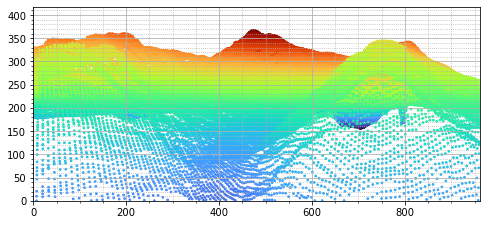

In [45]:
fig= plt.figure(figsize=(8,8))

plt.scatter(XYZ_Screen[ClippedPointIndex][:,0],
            XYZ_Screen[ClippedPointIndex][:,1], s=3,
            c=Vertices[ClippedPointIndex][:,2], cmap=plt.cm.turbo, label='Detected Corners')

# cbar = plt.colorbar(shrink=0.82)
# cbar.set_label('Z Screen (Depth)', rotation=90,fontsize=14)
plt.axis('scaled')

plt.xlim(0,ImageWidth)
plt.ylim(0,ImageHeight)
# plt.gca().invert_yaxis()  

# drawedges(XYZ_window[:,0:2])    
plt.grid(which='major')
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
# plt.legend(fontsize=14)
plt.show()

# Ray Tracing

In [55]:
Vertices_t = torch.tensor(Vertices)
TrianglesIndex_t = torch.tensor(TrianglesIndex, dtype=torch.int64)
Triangles_t = Vertices_t[TrianglesIndex_t]

ClippedPointIndex_t = torch.tensor(ClippedPointIndex, dtype=torch.int64)
ClippedPointInvisIndex_t = torch.tensor(ClippedPointInvisIndex, dtype=torch.int64)

In [56]:
VisClippedTriangleBool_t = ~torch.all(torch.isin(TrianglesIndex_t, ClippedPointInvisIndex_t),
                                      dim=1)
print(VisClippedTriangleBool_t.shape)

torch.Size([981677])


In [57]:
VisClippedTriangleIndx_t = TrianglesIndex_t[VisClippedTriangleBool_t]
print(VisClippedTriangleIndx_t.shape)

torch.Size([290896, 3])


In [58]:
MeshClipped = o3d.geometry.TriangleMesh()
MeshClipped.vertices = o3d.utility.Vector3dVector(np.asarray(Vertices))
MeshClipped.triangles = o3d.utility.Vector3iVector(VisClippedTriangleIndx_t.numpy())

#o3d.visualization.draw_geometries([MeshClipped], mesh_show_wireframe=True)
Custom_Visualizer_Mesh(MeshClipped)

[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


In [ ]:
def CheckOneVertex_With_AllTriangles(VERTEX, TRIANGLES, XYZ_CAMERA):
    
    
    TRIANGLES = torch.tensor(TRIANGLES)
    VERTEX = torch.tensor(VERTEX).unsqueeze(0)
    
    L_a = torch.tensor(XYZ_CAMERA)
    L_b = VERTEX
    L_AB = -(L_b - L_a)
    
    CoMAT = L_AB.repeat_interleave(3,dim=0).reshape(L_AB.shape[0], 3, 3)
    CoMAT2 = CoMAT.repeat_interleave(TRIANGLES.shape[0], dim=0).reshape(L_AB.shape[0], TRIANGLES.shape[0], 3, 3)
    CoMAT2[:,:,1,:] = TRIANGLES[:,1] - TRIANGLES[:,0]    #P_01
    CoMAT2[:,:,2,:] = TRIANGLES[:,2] - TRIANGLES[:,0]    #P_02
    CoMAT3 = CoMAT2.transpose(-2, -1)
    
    CoMAT_inv = torch.linalg.inv_ex(CoMAT3)[0]
    #check if one matrix is uninvertible with:
    #torch.linalg.inv_ex(CoMAT3)[1]  if there is any non-zero value
    
    B = (L_a - TRIANGLES[:,0]).reshape(TRIANGLES.shape[0],3,1)
    
    TUV = torch.matmul(CoMAT_inv, B)
    
    tol=1e-3
    
    check = (
    (TUV[:,:,0,:] < 1-tol) & (TUV[:,:,0,:] > tol) &
    (TUV[:,:,1,:] < 1-tol) & (TUV[:,:,1,:] > tol) &
    (TUV[:,:,2,:] < 1-tol) & (TUV[:,:,2,:] > tol) &
    (TUV[:,:,1,:]+TUV[:,:,2,:] < 1-tol))
    
    
    PointIsInvisible = torch.any(check).item()

    return TUV,PointIsInvisible

In [ ]:
def CheckVertexBatch_With_AllTriangles(VERTEX, TRIANGLES, XYZ_CAMERA):
    
    
    TRIANGLES = torch.tensor(TRIANGLES)
    VERTEX = torch.tensor(VERTEX)#.unsqueeze(0)
    
    L_a = torch.tensor(XYZ_CAMERA)
    L_b = VERTEX
    L_AB = -(L_b - L_a)
    
    CoMAT = L_AB.repeat_interleave(3,dim=0).reshape(L_AB.shape[0], 3, 3)
    CoMAT2 = CoMAT.repeat_interleave(TRIANGLES.shape[0], dim=0).reshape(L_AB.shape[0], TRIANGLES.shape[0], 3, 3)
    CoMAT2[:,:,1,:] = TRIANGLES[:,1] - TRIANGLES[:,0]    #P_01
    CoMAT2[:,:,2,:] = TRIANGLES[:,2] - TRIANGLES[:,0]    #P_02
    CoMAT3 = CoMAT2.transpose(-2, -1)
    
    CoMAT_inv = torch.linalg.inv_ex(CoMAT3)[0]
    #check if one matrix is uninvertible with:
    #torch.linalg.inv_ex(CoMAT3)[1]  if there is any non-zero value
    
    B = (L_a - TRIANGLES[:,0]).reshape(TRIANGLES.shape[0],3,1)
    
    TUV = torch.matmul(CoMAT_inv, B)
    
    tol=1e-3    
    check = (
    (TUV[:,:,0,:] < 1-tol) & (TUV[:,:,0,:] > tol) &
    (TUV[:,:,1,:] < 1-tol) & (TUV[:,:,1,:] > tol) &
    (TUV[:,:,2,:] < 1-tol) & (TUV[:,:,2,:] > tol) &
    (TUV[:,:,1,:]+TUV[:,:,2,:] < 1-tol))
    
#     tol=0.0  
#     check = (
#     (TUV[:,:,0,:] <= 1-tol) & (TUV[:,:,0,:] >= tol) &
#     (TUV[:,:,1,:] <= 1-tol) & (TUV[:,:,1,:] >= tol) &
#     (TUV[:,:,2,:] <= 1-tol) & (TUV[:,:,2,:] >= tol) &
#     (TUV[:,:,1,:]+TUV[:,:,2,:] <= 1-tol))    
    
    
    
    Index_of_invisiblePoints = torch.nonzero(check*1)[:,0]
    return Index_of_invisiblePoints.numpy()

In [ ]:
VisClippedTriangle = Vertices[VisClippedTriangleIndx_t.numpy()]
VisClippedVertices = Vertices[ClippedPointIndex]

In [ ]:
print(Triangles.shape)
print(VisClippedTriangle.shape)
print('------------')
print(Vertices.shape)
print(VisClippedVertices.shape)

In [ ]:
CameraPositionNP = Loc
CameraPositionNP

In [ ]:
# %%time

# BatchNumber = 10
# Index_start = 0
# Index_end = 0
# InvisibleIndices = []


# Index_start = 0
# Index_end = BatchNumber
# while Index_start < Vertices.shape[0]:
    

    
#     InvisibleIndex = CheckVertexBatch_With_AllTriangles(VisClippedVertices[Index_start:Index_end],
#                                                         VisClippedTriangle, CameraPositionNP)
#     InvisibleIndices.append(list(InvisibleIndex+Index_start))
    
#     if Index_end % 100 == 0: print(Index_end)
#     Index_start += BatchNumber
#     Index_end += BatchNumber
#     #if(Index_end==200): break

# InvisibleIndices = np.concatenate(InvisibleIndices).astype('int64')

In [65]:
VisibleClippedIndices = np.loadtxt('VisibleClippedIndices.out',
                             delimiter=',').astype('int64')

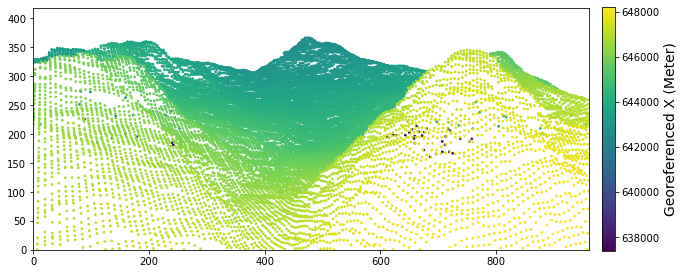

In [173]:
fig= plt.figure(figsize=(12,12))

plt.scatter(XYZ_Screen[ClippedPointIndex][VisibleClippedIndices][:,0],
            XYZ_Screen[ClippedPointIndex][VisibleClippedIndices][:,1], s=3,
            c=Vertices[ClippedPointIndex][VisibleClippedIndices][:,0], cmap=plt.cm.viridis, label='Detected Corners')

cbar = plt.colorbar(shrink=0.375, pad=0.02)
cbar.set_label('Georeferenced X (Meter)', rotation=90, fontsize=14)
plt.axis('scaled')

plt.xlim(0,ImageWidth)
plt.ylim(0,ImageHeight)
plt.show()

In [188]:
refinedindex_X = Vertices[ClippedPointIndex][VisibleClippedIndices][:,0] > 642000

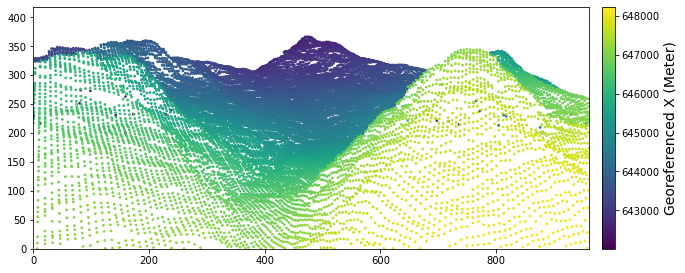

In [191]:
fig= plt.figure(figsize=(12,12))

plt.scatter(XYZ_Screen[ClippedPointIndex][VisibleClippedIndices][:,0][refinedindex_X],
            XYZ_Screen[ClippedPointIndex][VisibleClippedIndices][:,1][refinedindex_X], s=3,
            c=Vertices[ClippedPointIndex][VisibleClippedIndices][:,0][refinedindex_X], cmap=plt.cm.viridis, label='Detected Corners')

cbar = plt.colorbar(shrink=0.370, pad=0.02)
cbar.set_label('Georeferenced X (Meter)', rotation=90, fontsize=14)
plt.axis('scaled')

plt.xlim(0,ImageWidth)
plt.ylim(0,ImageHeight)
# plt.gca().invert_yaxis()  

# drawedges(XYZ_window[:,0:2])    
# plt.grid(which='major')
# plt.minorticks_on()
# plt.grid(which='minor', linestyle=':')
# plt.legend(fontsize=14)
plt.show()

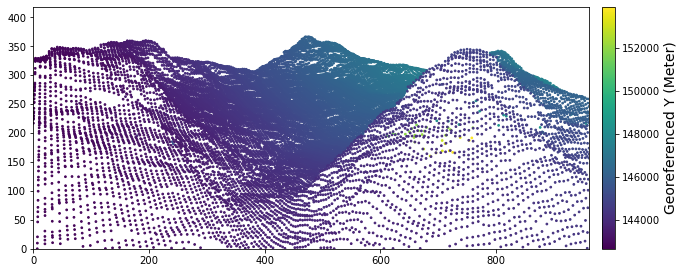

In [192]:
fig= plt.figure(figsize=(12,12))

plt.scatter(XYZ_Screen[ClippedPointIndex][VisibleClippedIndices][:,0],
            XYZ_Screen[ClippedPointIndex][VisibleClippedIndices][:,1], s=3,
            c=Vertices[ClippedPointIndex][VisibleClippedIndices][:,1], cmap=plt.cm.viridis, label='Detected Corners')

cbar = plt.colorbar(shrink=0.370, pad=0.02)
cbar.set_label('Georeferenced Y (Meter)', rotation=90, fontsize=14)
plt.axis('scaled')

plt.xlim(0,ImageWidth)
plt.ylim(0,ImageHeight)

plt.show()

In [155]:
refinedindex_Y = Vertices[ClippedPointIndex][VisibleClippedIndices][:,1] < 147500

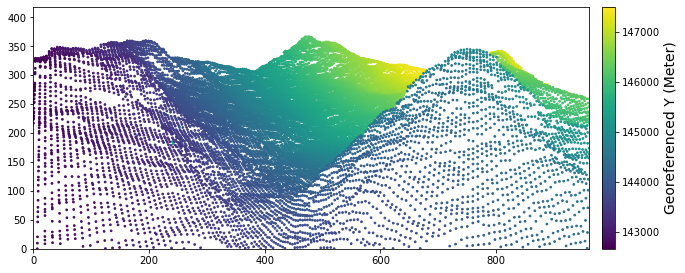

In [193]:
fig= plt.figure(figsize=(12,12))

plt.scatter(XYZ_Screen[ClippedPointIndex][VisibleClippedIndices][:,0][refinedindex_Y],
            XYZ_Screen[ClippedPointIndex][VisibleClippedIndices][:,1][refinedindex_Y], s=3,
            c=Vertices[ClippedPointIndex][VisibleClippedIndices][:,1][refinedindex_Y], cmap=plt.cm.viridis, label='Detected Corners')

cbar = plt.colorbar(shrink=0.370, pad=0.02)
cbar.set_label('Georeferenced Y (Meter)', rotation=90, fontsize=14)
plt.axis('scaled')

plt.xlim(0,ImageWidth)
plt.ylim(0,ImageHeight)
# plt.gca().invert_yaxis()  

# drawedges(XYZ_window[:,0:2])    
# plt.grid(which='major')
# plt.minorticks_on()
# plt.grid(which='minor', linestyle=':')
# plt.legend(fontsize=14)
plt.show()

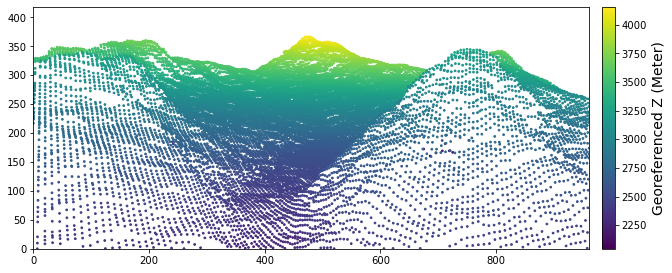

In [194]:
fig= plt.figure(figsize=(12,12))

plt.scatter(XYZ_Screen[ClippedPointIndex][VisibleClippedIndices][:,0],
            XYZ_Screen[ClippedPointIndex][VisibleClippedIndices][:,1], s=3,
            c=Vertices[ClippedPointIndex][VisibleClippedIndices][:,2], cmap=plt.cm.viridis , label='Detected Corners')

cbar = plt.colorbar(shrink=0.370, pad=0.02)
cbar.set_label('Georeferenced Z (Meter)', rotation=90, fontsize=14)
plt.axis('scaled')

plt.xlim(0,ImageWidth)
plt.ylim(0,ImageHeight)

plt.show()

In [179]:
refinedindex_Z = Vertices[ClippedPointIndex][VisibleClippedIndices][:,2] > 2250

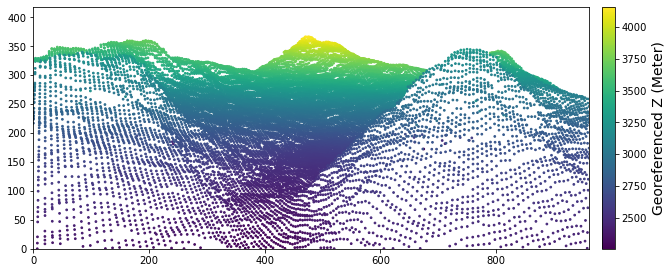

In [195]:
fig= plt.figure(figsize=(12,12))

plt.scatter(XYZ_Screen[ClippedPointIndex][VisibleClippedIndices][:,0][refinedindex_Z],
            XYZ_Screen[ClippedPointIndex][VisibleClippedIndices][:,1][refinedindex_Z], s=3,
            c=Vertices[ClippedPointIndex][VisibleClippedIndices][:,2][refinedindex_Z], cmap=plt.cm.viridis , label='Detected Corners')

cbar = plt.colorbar(shrink=0.370, pad=0.02)
cbar.set_label('Georeferenced Z (Meter)', rotation=90, fontsize=14)
plt.axis('scaled')

plt.xlim(0,ImageWidth)
plt.ylim(0,ImageHeight)

plt.show()